# Benchmarking 2D / 3D PORTRAITS + Correlation diagrams + Correlation factors 
--------

In [1]:
# import
from multidimvis_main import *

### TOY NETWORKS

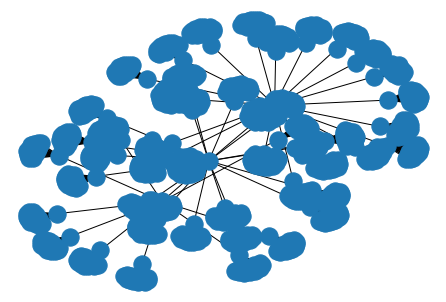

In [488]:
# TREE GRAPH
organism = 'tree'
n = 1000 # number of nodes
r = 20 # branching factor
G = nx.full_rary_tree(r, n)
nx.draw(G)

# STAR GRAPH
#organism = 'star'
#n = 1000
#G = nx.star_graph(n)

# CYCLE GRAPH
#organism = 'cycle'
#n = 1000
#G = nx.cycle_graph(n)

### GEOMETRIES 

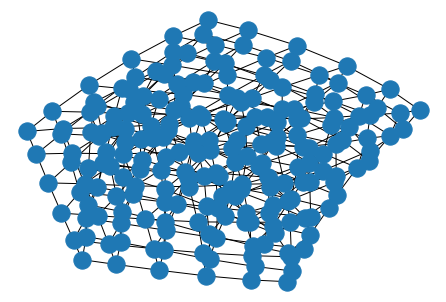

In [656]:
# 3D grid 
organism = 'grid'

G_grid = nx.grid_graph([6,6,6],periodic=False)
G = G_grid 
nx.draw(G)

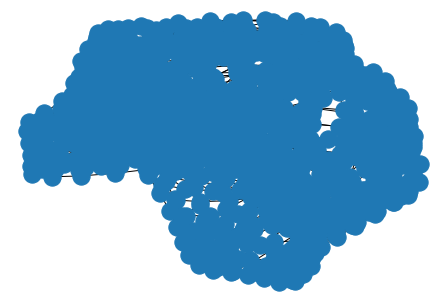

In [372]:
# Torus 
organism = 'torus'

G_tor = nx.grid_2d_graph(48,24,periodic=True) #24,12
G = G_tor
nx.draw(G)

## NETWORK

In [657]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 216
Number of edges: 540
Network density: 2.3%


+ Feature Collection 

In [658]:
# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)
    
# CLOSENESSCENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)
    
# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)
    
# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)

In [659]:
d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}

# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                    )))

# IMPORTANT :
# sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
feature_df = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen',
                                                                                      ]) 

In [660]:
feature_df.head()

,degs,clos,betw,eigen
"(0, 0, 0)",0.5000,0.1327,0.0012,0.0125
"(0, 0, 1)",0.6667,0.1457,0.0057,0.0225
"(0, 0, 2)",0.6667,0.1531,0.0074,0.0280
"(0, 0, 3)",0.6667,0.1531,0.0074,0.0280
"(0, 0, 4)",0.6667,0.1457,0.0057,0.0225


+ Matrices

In [661]:
# Adjacency
A = nx.adjacency_matrix(G)
adj = A.toarray()
DM_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))

In [662]:
DM_adj.head() 

,"(0, 0, 0)","(0, 0, 1)","(0, 0, 2)","(0, 0, 3)","(0, 0, 4)","(0, 0, 5)","(0, 1, 0)","(0, 1, 1)","(0, 1, 2)","(0, 1, 3)",...,"(5, 4, 2)","(5, 4, 3)","(5, 4, 4)","(5, 4, 5)","(5, 5, 0)","(5, 5, 1)","(5, 5, 2)","(5, 5, 3)","(5, 5, 4)","(5, 5, 5)"
"(0, 0, 0)",0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 0, 1)",1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 0, 2)",0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 0, 3)",0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
"(0, 0, 4)",0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [663]:
r = .8 # restart probability; originally 0.8
alpha = 1.0 
# alpha = 0.5 # --> better results for torus 

DM_m = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))

DM_m_df = pd.DataFrame(DM_m)
#print(DM_m_df.sum(axis=0))

DM_m_transposed = DM_m_df.T

metric = "cosine" 
DM_m_new = pd.DataFrame(distance.squareform(distance.pdist(DM_m_transposed, metric)))
DM_m_new.index = list(G.nodes())
DM_m_new.columns = list(G.nodes())

In [664]:
DM_m = DM_m_new
DM_m.head()

,"(0, 0, 0)","(0, 0, 1)","(0, 0, 2)","(0, 0, 3)","(0, 0, 4)","(0, 0, 5)","(0, 1, 0)","(0, 1, 1)","(0, 1, 2)","(0, 1, 3)",...,"(5, 4, 2)","(5, 4, 3)","(5, 4, 4)","(5, 4, 5)","(5, 5, 0)","(5, 5, 1)","(5, 5, 2)","(5, 5, 3)","(5, 5, 4)","(5, 5, 5)"
"(0, 0, 0)",0.000000,0.881890,0.990566,0.999345,0.999958,0.999997,0.881890,0.983642,0.998508,0.999886,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"(0, 0, 1)",0.881890,0.000000,0.898812,0.992295,0.999477,0.999958,0.983987,0.908350,0.987612,0.998872,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"(0, 0, 2)",0.990566,0.898812,0.000000,0.898856,0.992295,0.999345,0.998539,0.987607,0.908584,0.987629,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"(0, 0, 3)",0.999345,0.992295,0.898856,0.000000,0.898812,0.990566,0.999888,0.998871,0.987629,0.908584,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"(0, 0, 4)",0.999958,0.999477,0.992295,0.898812,0.000000,0.881890,0.999992,0.999914,0.998872,0.987612,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [665]:
metric = "cosine" 
DM_cent = pd.DataFrame(distance.squareform(distance.pdist(feature_df, metric)))
DM_cent.index = list(G.nodes())
DM_cent.columns = list(G.nodes())

In [666]:
DM_cent.head()

,"(0, 0, 0)","(0, 0, 1)","(0, 0, 2)","(0, 0, 3)","(0, 0, 4)","(0, 0, 5)","(0, 1, 0)","(0, 1, 1)","(0, 1, 2)","(0, 1, 3)",...,"(5, 4, 2)","(5, 4, 3)","(5, 4, 4)","(5, 4, 5)","(5, 5, 0)","(5, 5, 1)","(5, 5, 2)","(5, 5, 3)","(5, 5, 4)","(5, 5, 5)"
"(0, 0, 0)",0.000000,1.035481e-03,0.000743,0.000743,1.035481e-03,0.000000,1.035481e-03,0.002694,0.002438,0.002438,...,0.002438,0.002438,0.002694,1.035481e-03,0.000000,1.035481e-03,0.000743,0.000743,1.035481e-03,0.000000
"(0, 0, 1)",0.001035,0.000000e+00,0.000090,0.000090,1.110223e-16,0.001035,1.110223e-16,0.000427,0.000513,0.000513,...,0.000513,0.000513,0.000427,1.110223e-16,0.001035,1.110223e-16,0.000090,0.000090,1.110223e-16,0.001035
"(0, 0, 2)",0.000743,9.040232e-05,0.000000,0.000000,9.040232e-05,0.000743,9.040232e-05,0.000631,0.000502,0.000502,...,0.000502,0.000502,0.000631,9.040232e-05,0.000743,9.040232e-05,0.000000,0.000000,9.040232e-05,0.000743
"(0, 0, 3)",0.000743,9.040232e-05,0.000000,0.000000,9.040232e-05,0.000743,9.040232e-05,0.000631,0.000502,0.000502,...,0.000502,0.000502,0.000631,9.040232e-05,0.000743,9.040232e-05,0.000000,0.000000,9.040232e-05,0.000743
"(0, 0, 4)",0.001035,1.110223e-16,0.000090,0.000090,0.000000e+00,0.001035,1.110223e-16,0.000427,0.000513,0.000513,...,0.000513,0.000513,0.000427,1.110223e-16,0.001035,1.110223e-16,0.000090,0.000090,1.110223e-16,0.001035


In [719]:
#feature = 'adj'
#DM = DM_adj

#feature = 'rwr'
#DM = DM_m

feature = 'cent'
DM = DM_cent

____________
# 3 | SET VISUAL PRE-SETTINGS
____________

### GENERAL NODE + EDGE PARAMETERS

In [720]:
# Node, Edge colors

edge_width = 2
edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 1

opacity_nodes = 1.0
node_edge_col = None


# Node sizes 

scalef= 0.2
size = list(draw_node_degree(G, scalef).values())

scalef= 0.05
size3d = list(draw_node_degree_3D(G, scalef).values())

### SPECIFIC NODE + EDGE PARAMETERS

In [721]:
color_method = 'clos'
d_to_be_col = d_clos # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)
colours = color_nodes_from_dict(G, d_to_be_col, color_method)

# 2D PORTRAITS

### SPRING

In [722]:
%%time 

# ---------------------------------------
# Spring
# ---------------------------------------
forceatlas2 = ForceAtlas2()
#posG_spring = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=200)
posG_spring2D = nx.spring_layout(G, dim = 2)

CPU times: user 97.5 ms, sys: 3.99 ms, total: 101 ms
Wall time: 99.7 ms


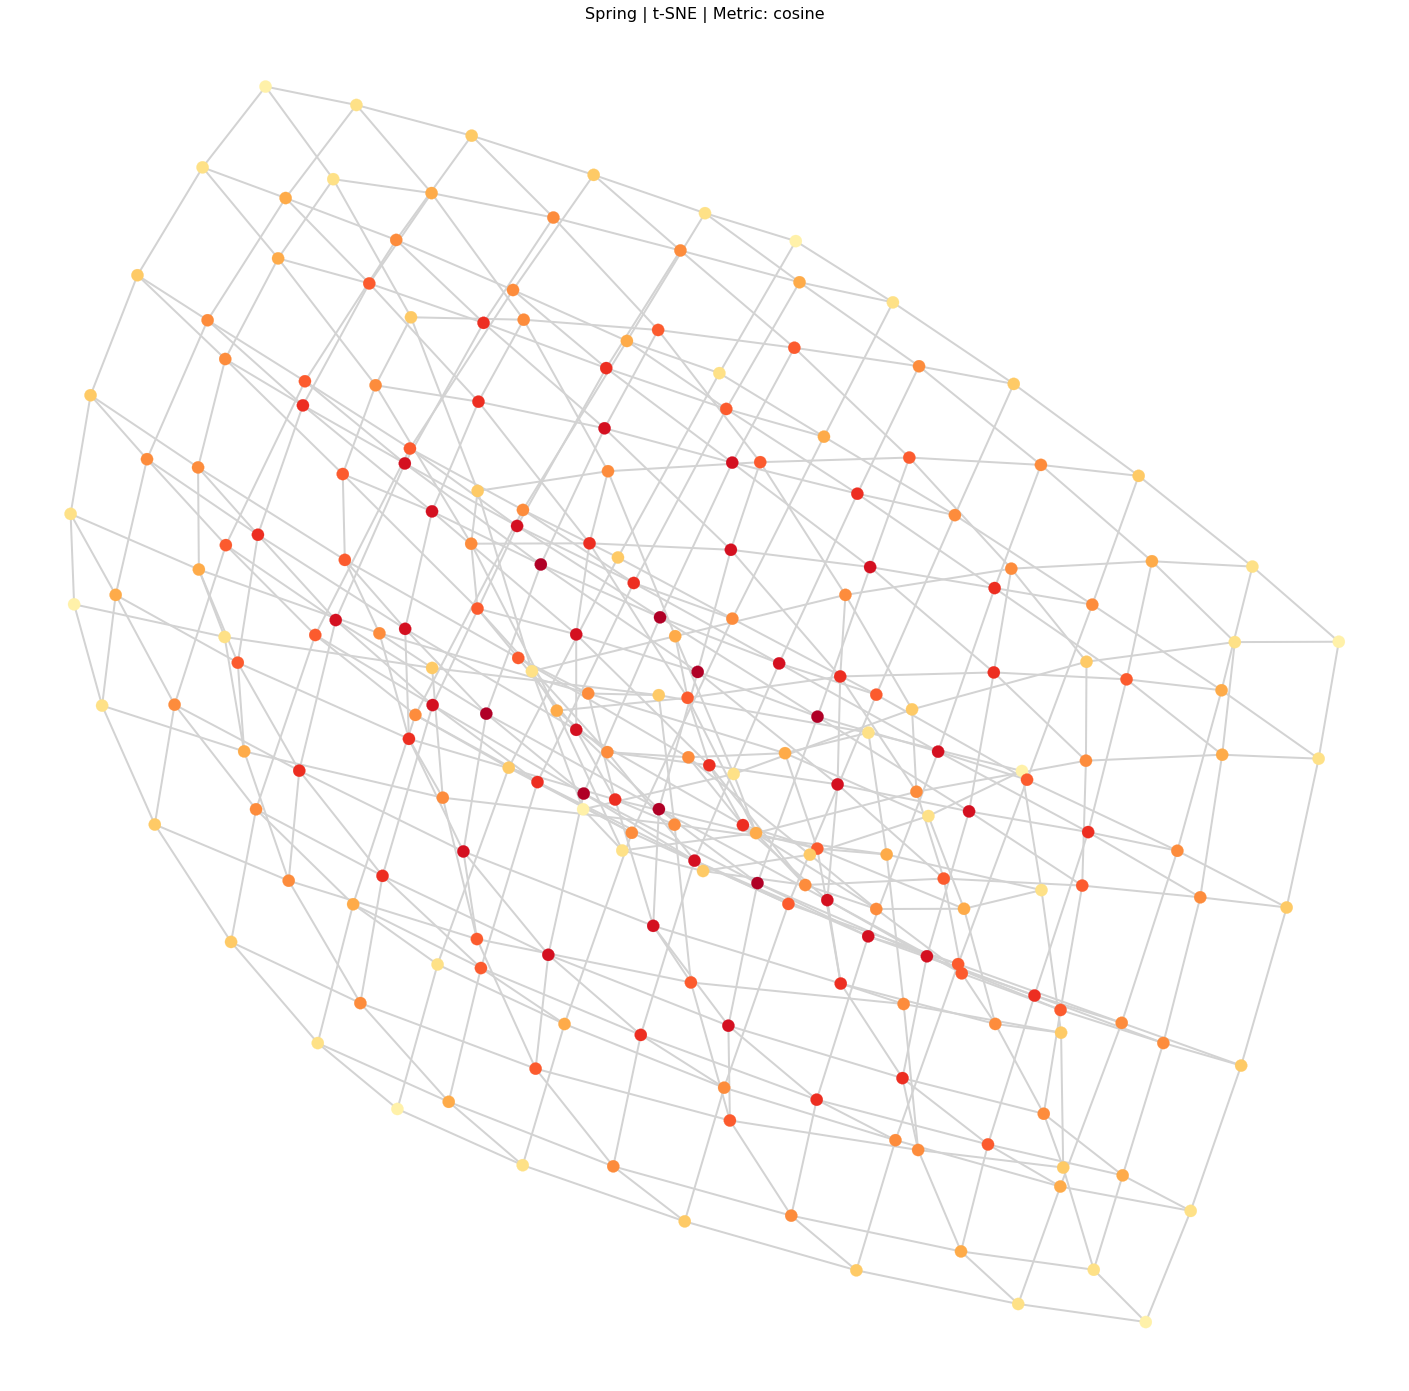

In [723]:
plt.figure(figsize=(25,25))
plt.title('Spring | t-SNE | Metric: '+metric, size= 16)

nx.draw_networkx_nodes(G, posG_spring2D, edgecolors = node_edge_col, linewidths = 0.25, node_color = colours, 
                       node_size= 150, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_spring2D, width = edge_width, edge_color = edge_col, alpha = opacity_edges)

plt.box(False)

plt.savefig('output_plots/2Dspring_'+organism+'.png')

plt.show()

### UMAP 

In [724]:
n_neighbors = 12 # balance between local and global structure in the data
spread = 70.0
min_dist = 0.1 # defines how dense points are stacked together 
metric ='cosine'

In [725]:
%%time 
umap = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



CPU times: user 3.96 s, sys: 456 ms, total: 4.41 s
Wall time: 2.32 s


In [726]:
posG_umap = get_posG_2D(G.nodes(), umap)
posG_complete_umap = {key:posG_umap[key] for key in G.nodes()}

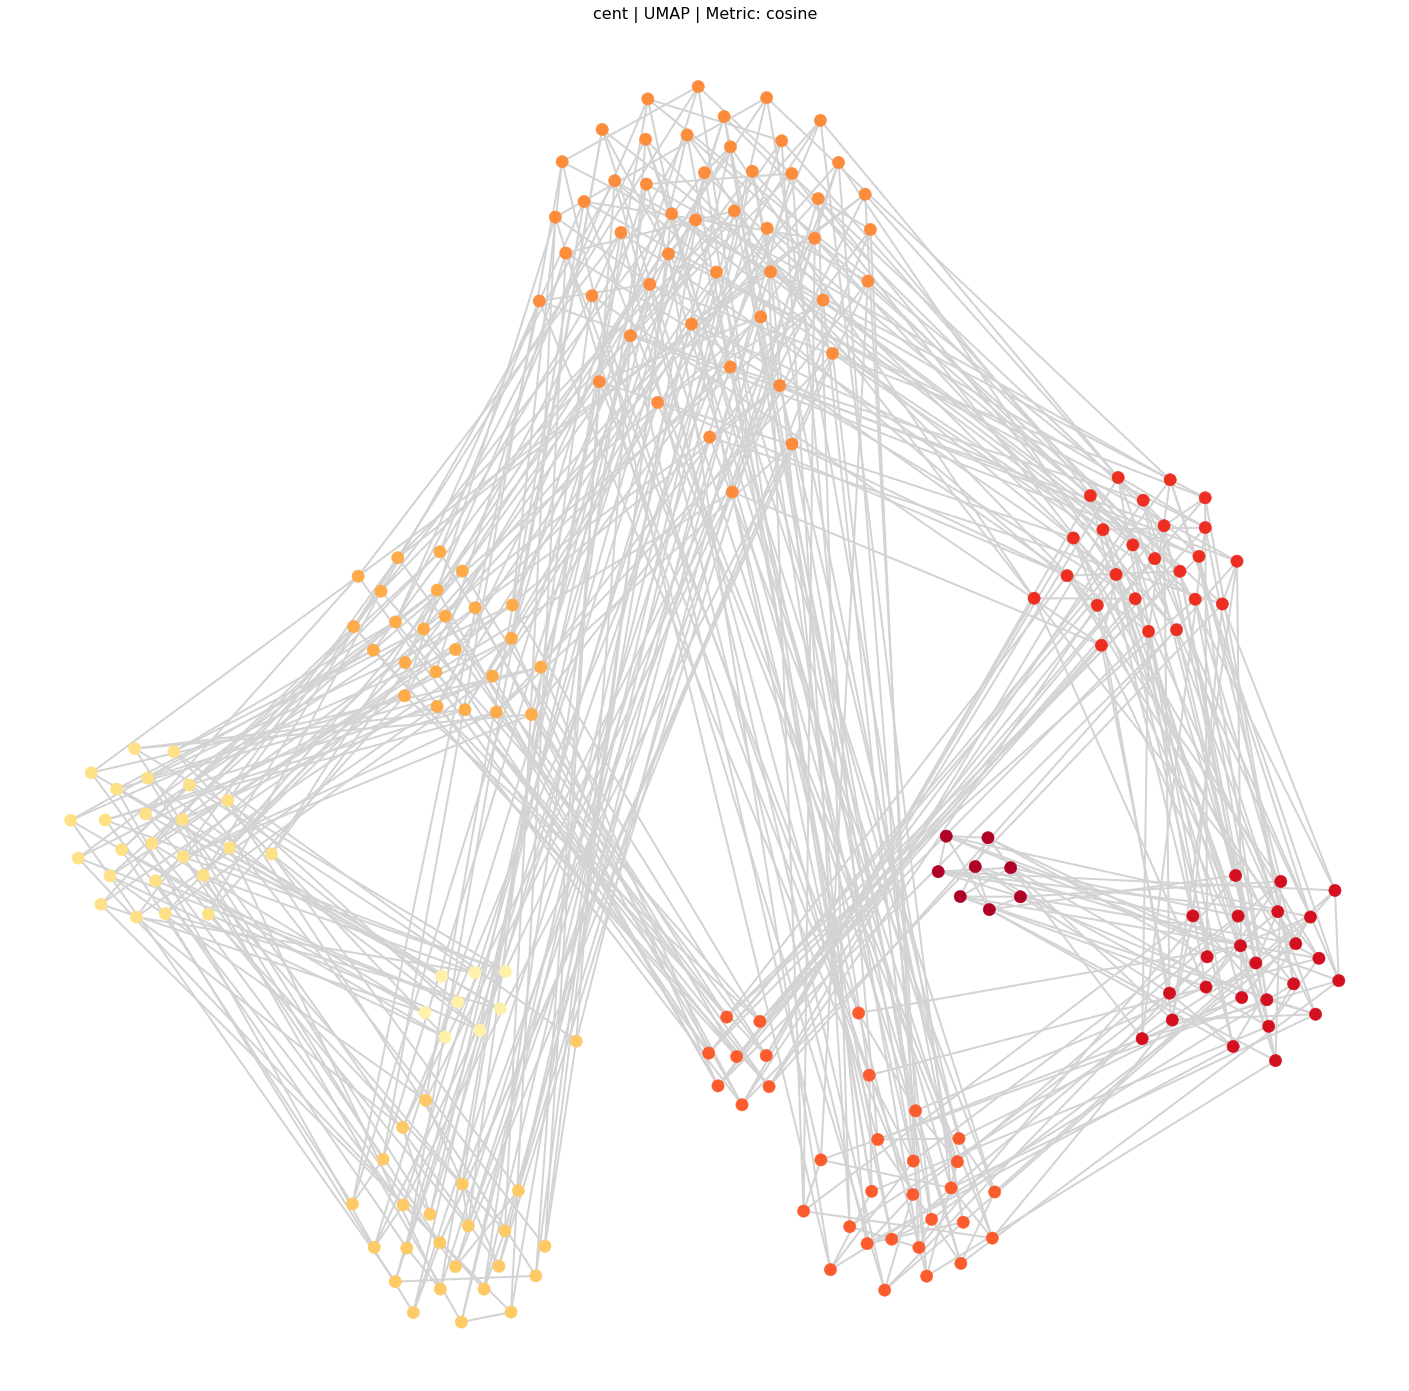

In [727]:
plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 150, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap, width = edge_width, edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

# 3D SPRING

In [728]:
posG_spring3D = nx.spring_layout(G, dim = 3)

spring_nodes = get_trace_nodes_3D(posG_spring3D, None, colours, 4) #size3d)
spring_edges = get_trace_edges_3D(G, posG_spring3D, edge_colordark, opac=1)

spring_data = [spring_nodes, spring_edges]

In [729]:
print('Spring Layout:', organism)

fig = pgo.Figure()
for i in spring_data:
    fig.add_trace(i)
'''fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                    dragmode="turntable",
                    #annotations=annotations,
                ))'''

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_'+'spring_'+organism+'.html', auto_open=True)

Spring Layout: grid


'output_plots/3Dtoynetwork_spring_grid.html'

# 3D PORTRAITS

### UMAP 

In [730]:
n_neighbors = 15 # balance between local and global structure in the data
spread = 90.0
min_dist = 0.1 # defines how dense points are stacked together 
metric='cosine'

In [731]:
%%time 
umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



CPU times: user 4.36 s, sys: 138 ms, total: 4.5 s
Wall time: 2.17 s


In [732]:
posG_3Dumap = get_posG_3D(list(G.nodes()), umap_3D)
posG_3D_complete_umap = {key:posG_3Dumap[key] for key in G.nodes()}

In [733]:
%%time 
umap_nodes = get_trace_nodes_3D(posG_3D_complete_umap, None, colours, 4) # size3d)
umap_edges = get_trace_edges_3D(G, posG_3D_complete_umap, edge_colordark, 1.0) 

umap_data = [umap_edges, umap_nodes]
#umap_data = [umap_nodes]

CPU times: user 14.3 ms, sys: 810 µs, total: 15.1 ms
Wall time: 14.8 ms


In [734]:
fig = pgo.Figure()
for i in umap_data:
    fig.add_trace(i)

'''fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    '''

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

'output_plots/3Dtoynetwork_umap_cent_grid.html'

_________

# EVALUATION OF Layouts compared to Spring
### CALCULATE DISTANCES OF NODES IN LAYOUTS
+ Plots to test "Original Distances" with embedded Distances 
+ X-axis = distances of layout, Y-axis = actual Distance Matrix Distances

## 2D layouts Correlation diagrams 

In [735]:
# get all possible combinations of points
# keys of the dictionary are : (p1,p2),(p2,p3),... 
# values are distances from p1 to p2

from itertools import combinations
dist_spring2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_spring2D.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_spring2D[id1,id2] = math.sqrt(dx*dx+dy*dy)
    

from itertools import combinations
dist_layout2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = math.sqrt(dx*dx+dy*dy)

In [736]:
# get squareform dataframes from distances (spring, layout)

dist_spring_list = [dist[1] for dist in sorted(dist_spring2D.items())]
df_spring2D = pd.DataFrame(dist.squareform(dist_spring_list), index=DM.index, columns=DM.columns)

dist_layout_list = [dist[1] for dist in sorted(dist_layout2D.items())]
df_layout2D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)

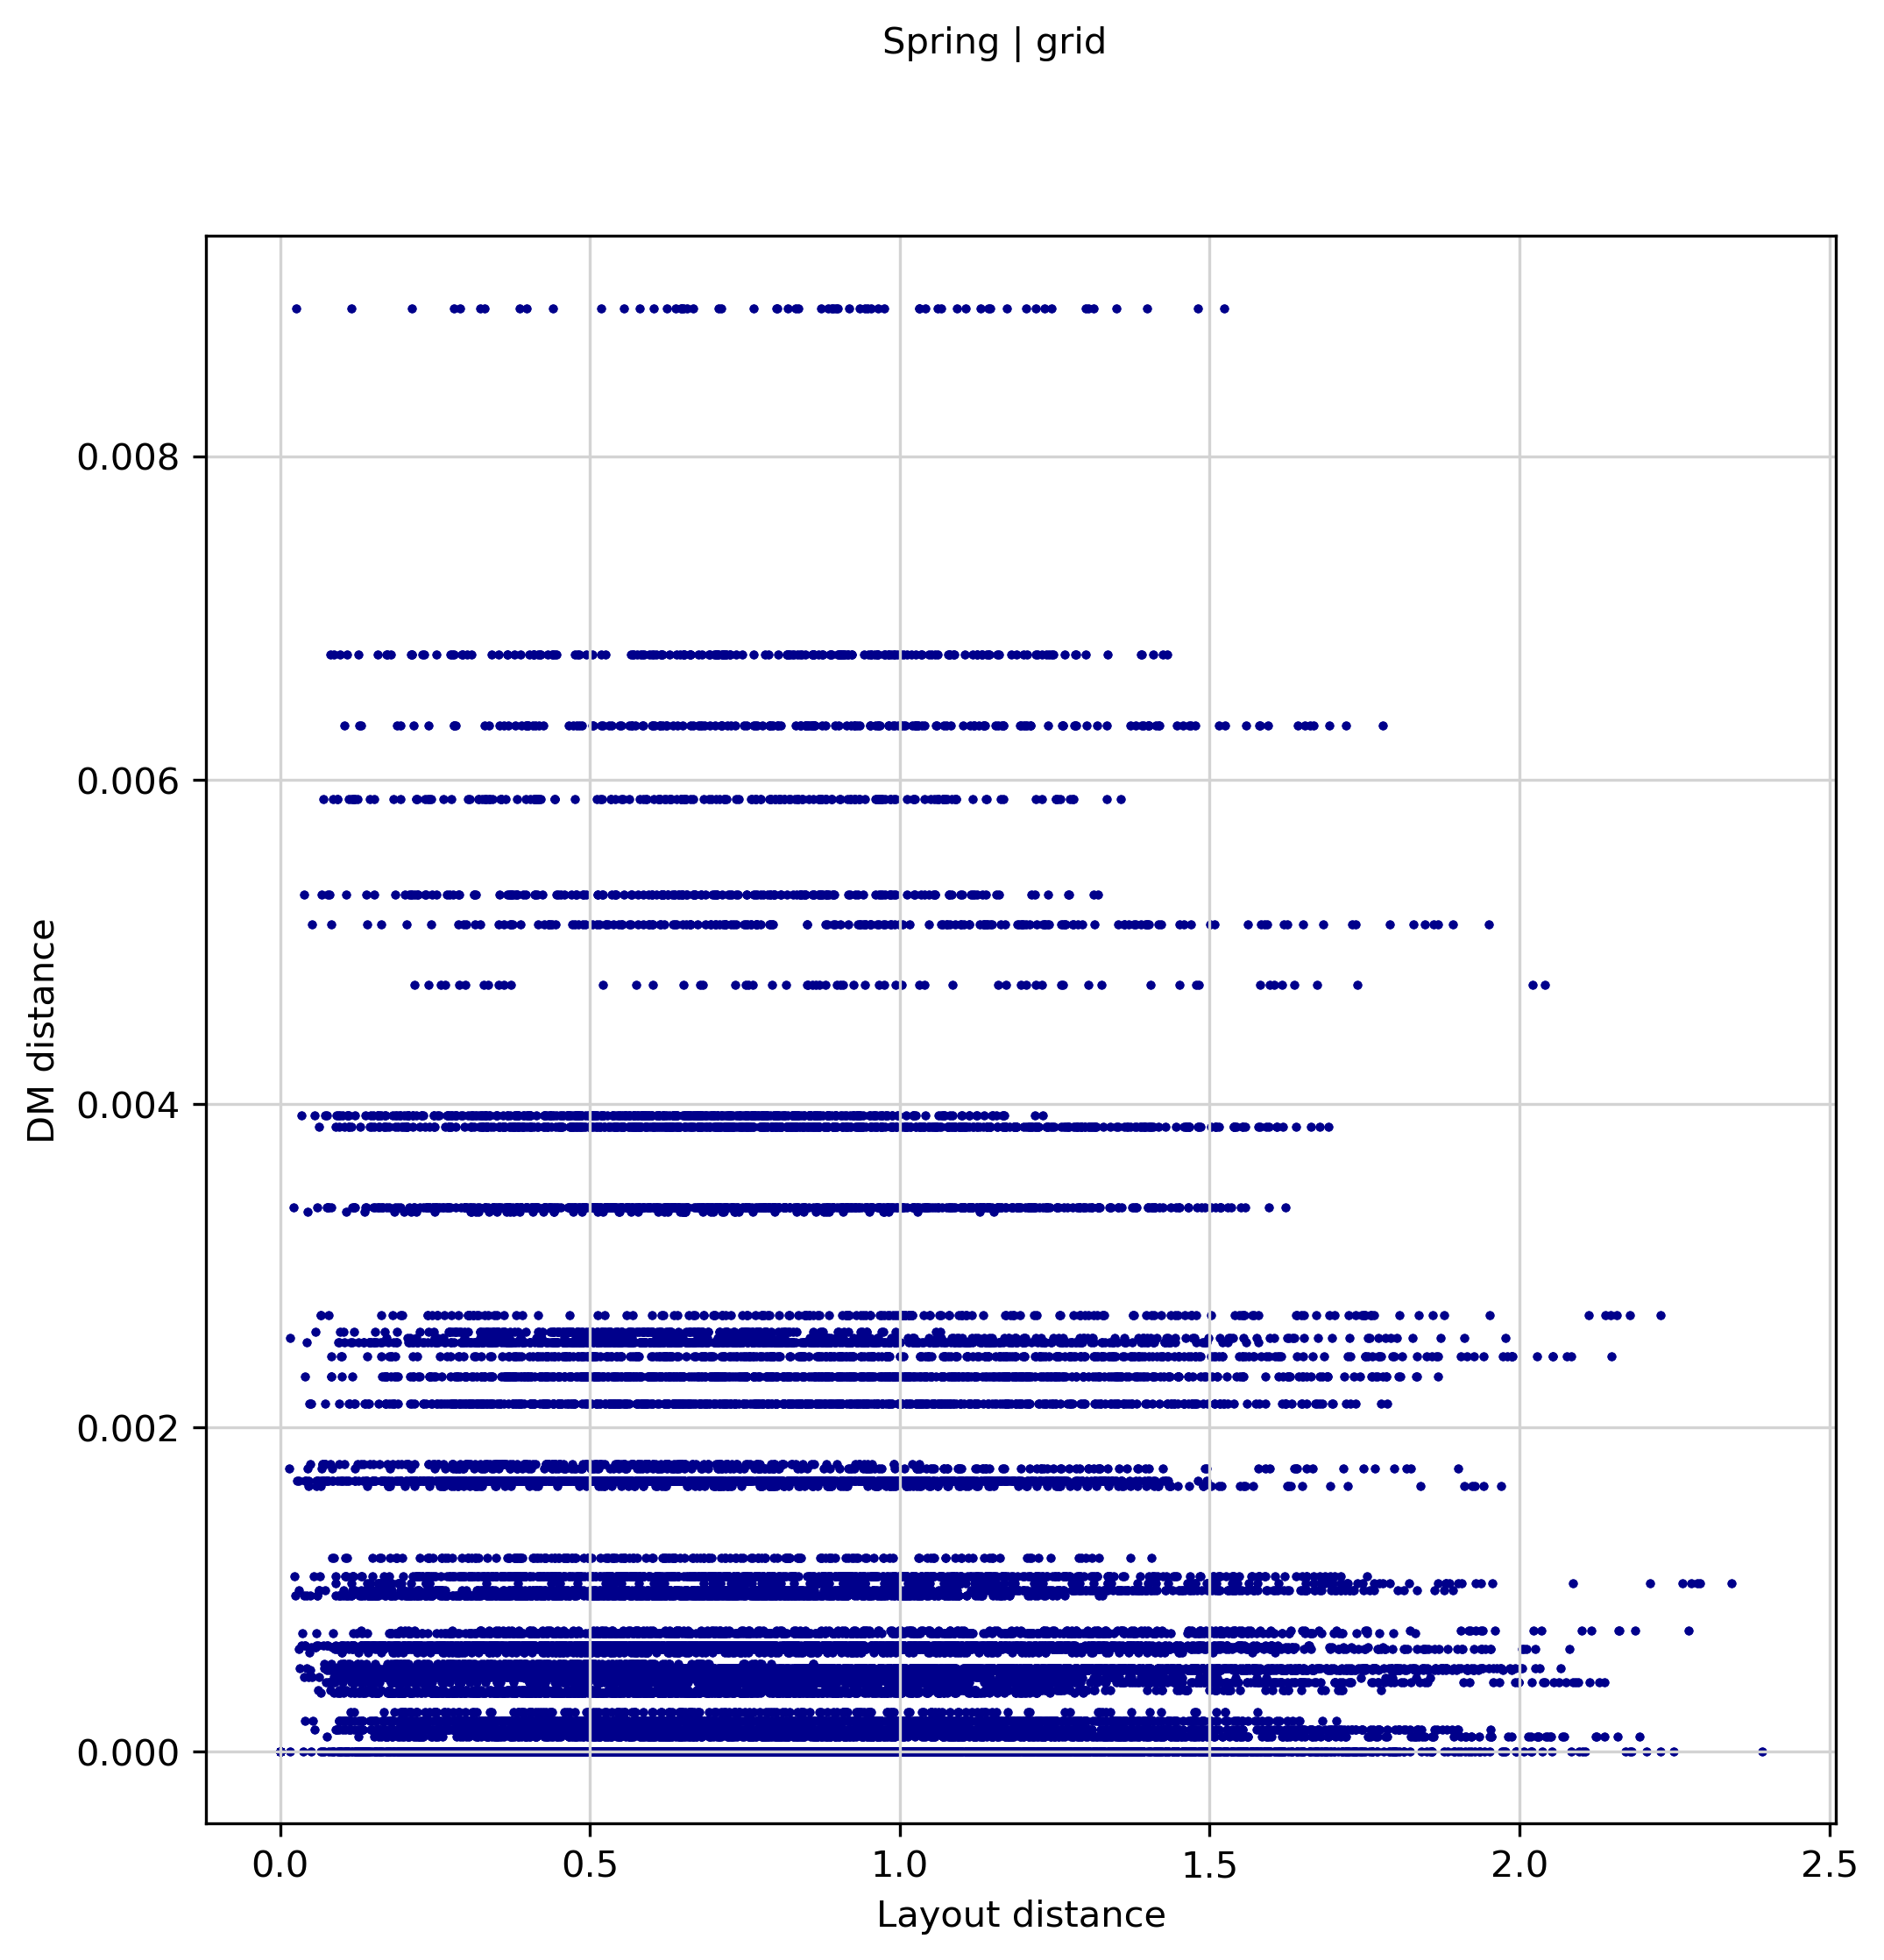

In [737]:
fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True,c='lightgrey')

#for i in df_spring2D:
#    plt.scatter(df_spring2D.values[i],DM.values[i], c = 'darkblue', s = 2)

plt.scatter(df_spring2D.values,DM.values, c = 'darkblue', s = 2)
plt.xlabel("Layout distance", fontsize=10)
plt.ylabel("DM distance", fontsize=10)

fig.suptitle('Spring | '+organism, fontsize=10)

#slope, intercept, r_value, p_value, std_err = stats.linregress(df_spring2D.values,DM.values)
#line = slope*df_spring2D.values[i]+intercept
#plt.plot(df_spring2D.values[i], line, c='black',linewidth=1.0, label='y={:.2f}x+{:.2f}'.format(slope,intercept))

#plt.legend(fontsize=14)

fig.savefig('output_plots/2Dtoynetwork_CorrDiagramSPRING_'+feature+'_'+organism+'.png')

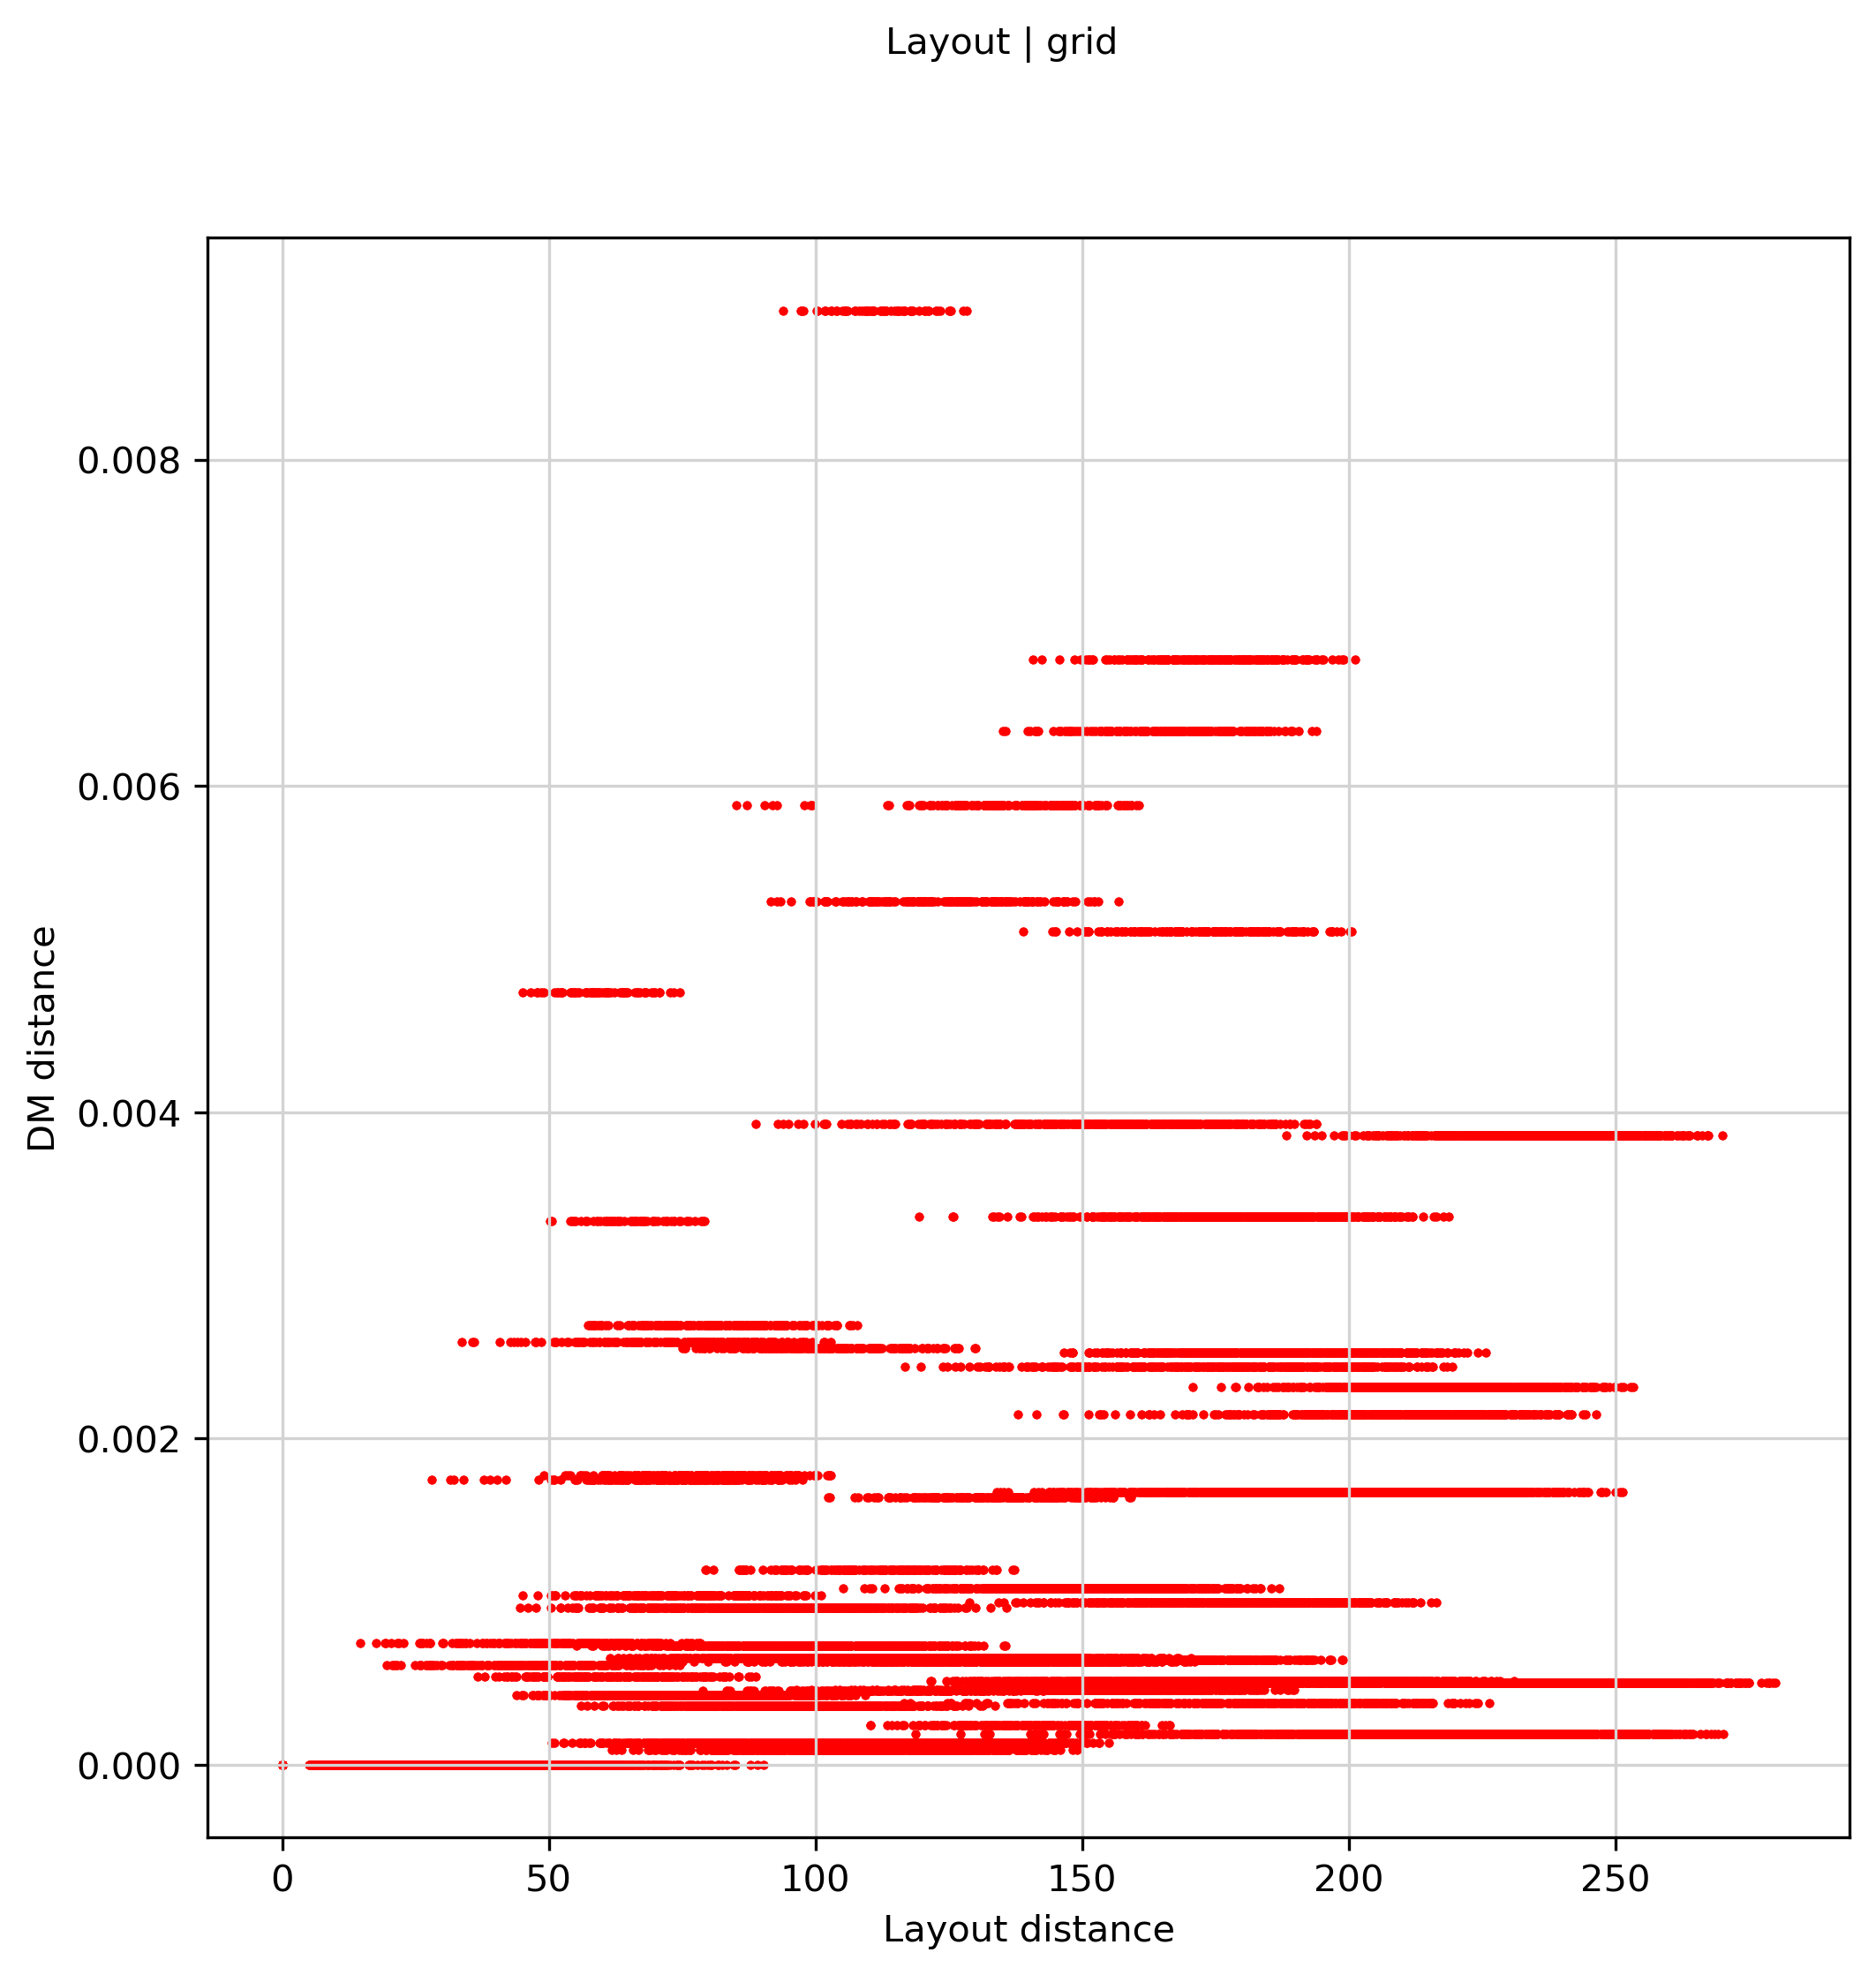

In [738]:
fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True,c='lightgrey')


#for i in df_layout2D:
#    plt.scatter(df_layout2D.values[i],DM.values[i], c = 'red', s = 2)

plt.scatter(df_layout2D.values,DM.values, c = 'red', s = 2)

plt.xlabel("Layout distance", fontsize=10)
plt.ylabel("DM distance", fontsize=10)

fig.suptitle('Layout | '+organism, fontsize=10)

#slope, intercept, r_value, p_value, std_err = stats.linregress(df_layout2D.values[i],DM.values[i])
#line = slope*df_layout2D.values[i]+intercept
#plt.plot(df_layout2D.values[i], line, c='darkred',linewidth=1.0, label='y={:.2f}x+{:.2f}'.format(slope,intercept))

#plt.legend(fontsize=14)

fig.savefig('output_plots/2Dtoynetwork_CorrDiagramLAYOUT_'+feature+'_'+organism+'.png')

## 3D layouts Correlation diagrams

In [739]:
# get all possible combinations of points
# keys of the dictionary are : (p1,p2),(p2,p3),... 
# values are distances from p1 to p2

from itertools import combinations
dist_spring3D = dict()
for (id1,p1),(id2,p2) in combinations(posG_spring3D.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    

from itertools import combinations
dist_layout3D = dict()
for (id1,p1),(id2,p2) in combinations(posG_3D_complete_umap.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)

In [740]:
# get squareform dataframes from distances (spring, layout)

dist_spring3D_list = [dist[1] for dist in sorted(dist_spring3D.items())]
df_spring3D = pd.DataFrame(dist.squareform(dist_spring3D_list), index=DM.index, columns=DM.columns)

dist_layout3D_list = [dist[1] for dist in sorted(dist_layout3D.items())]
df_layout3D = pd.DataFrame(dist.squareform(dist_layout3D_list), index=DM.index, columns=DM.columns)

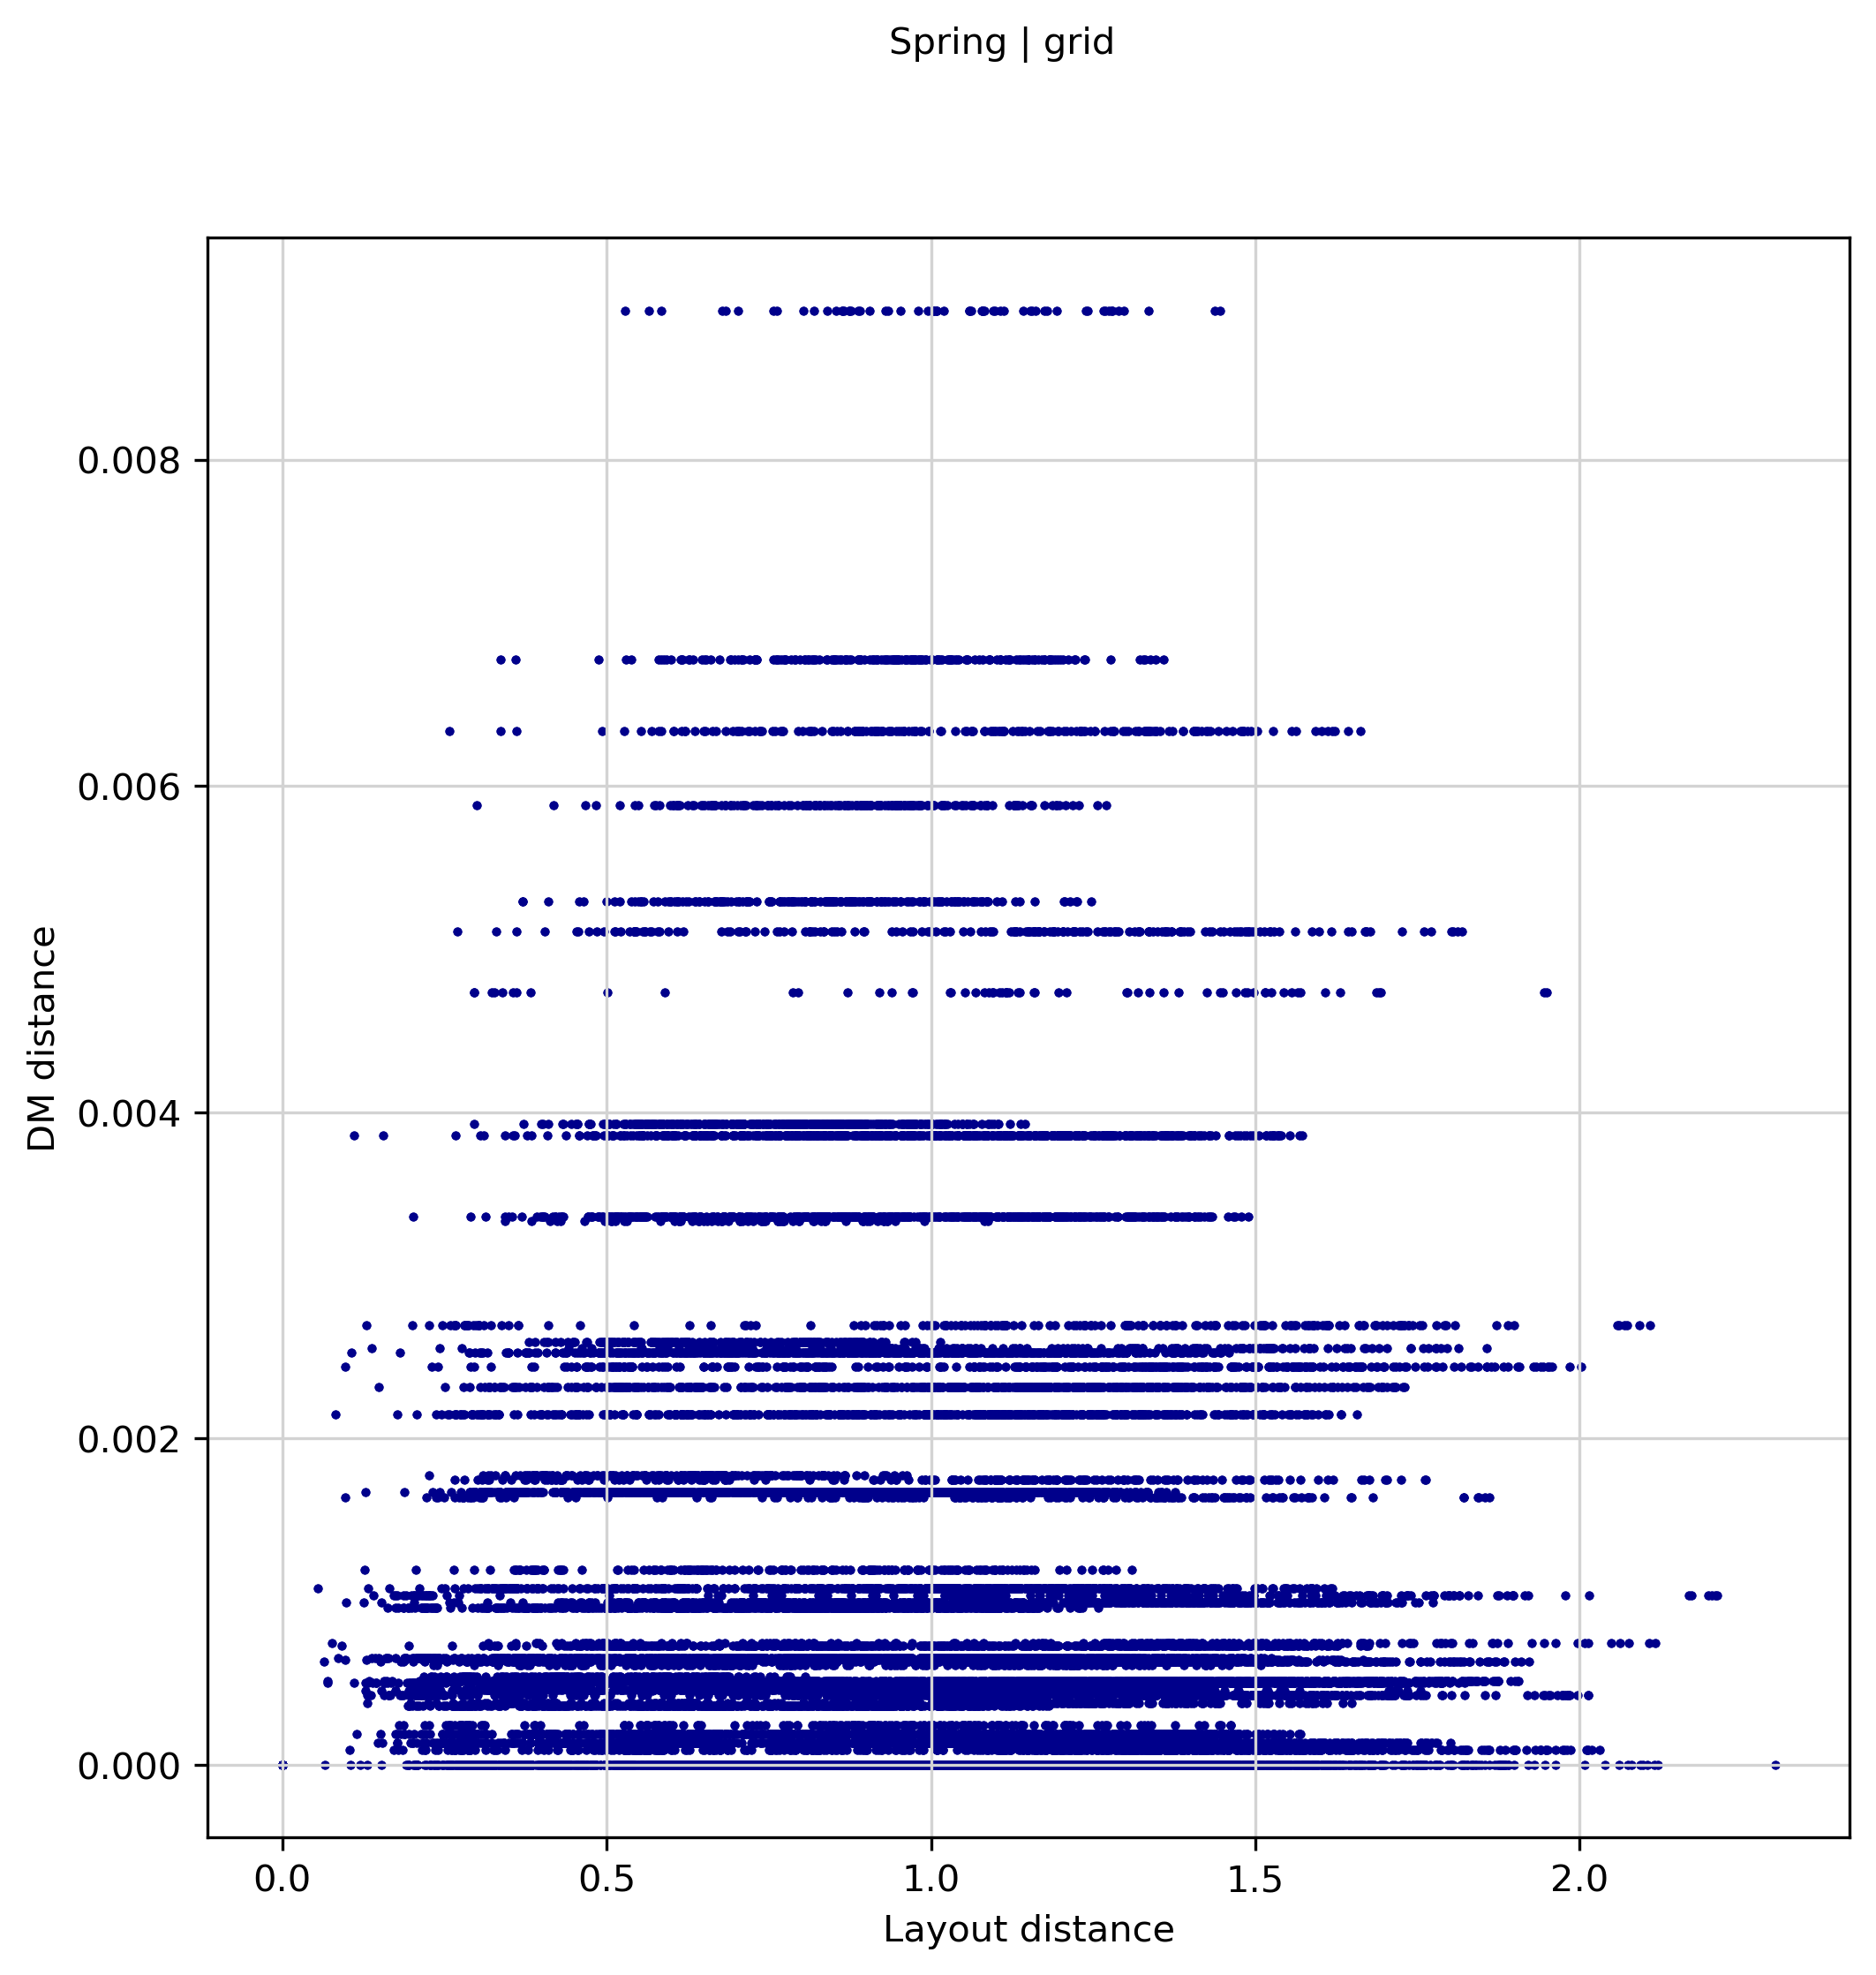

In [741]:
fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True,c='lightgrey')

#for i in df_spring3D:
#    plt.scatter(df_spring3D.values[i],DM.values[i], c = 'darkblue', s = 2)

plt.scatter(df_spring3D.values,DM.values, c = 'darkblue', s = 2)

plt.xlabel("Layout distance", fontsize=10)
plt.ylabel("DM distance", fontsize=10)

fig.suptitle('Spring | '+organism, fontsize=10)

#slope, intercept, r_value, p_value, std_err = stats.linregress(df_spring3D.values[i],DM.values[i])
#line = slope*df_spring3D.values[i]+intercept
#plt.plot(df_spring3D.values[i], line, c='black',linewidth=1.0, label='y={:.2f}x+{:.2f}'.format(slope,intercept))

#plt.legend(fontsize=14)

fig.savefig('output_plots/3Dtoynetwork_CorrDiagramSPRING_'+feature+'_'+organism+'.png')

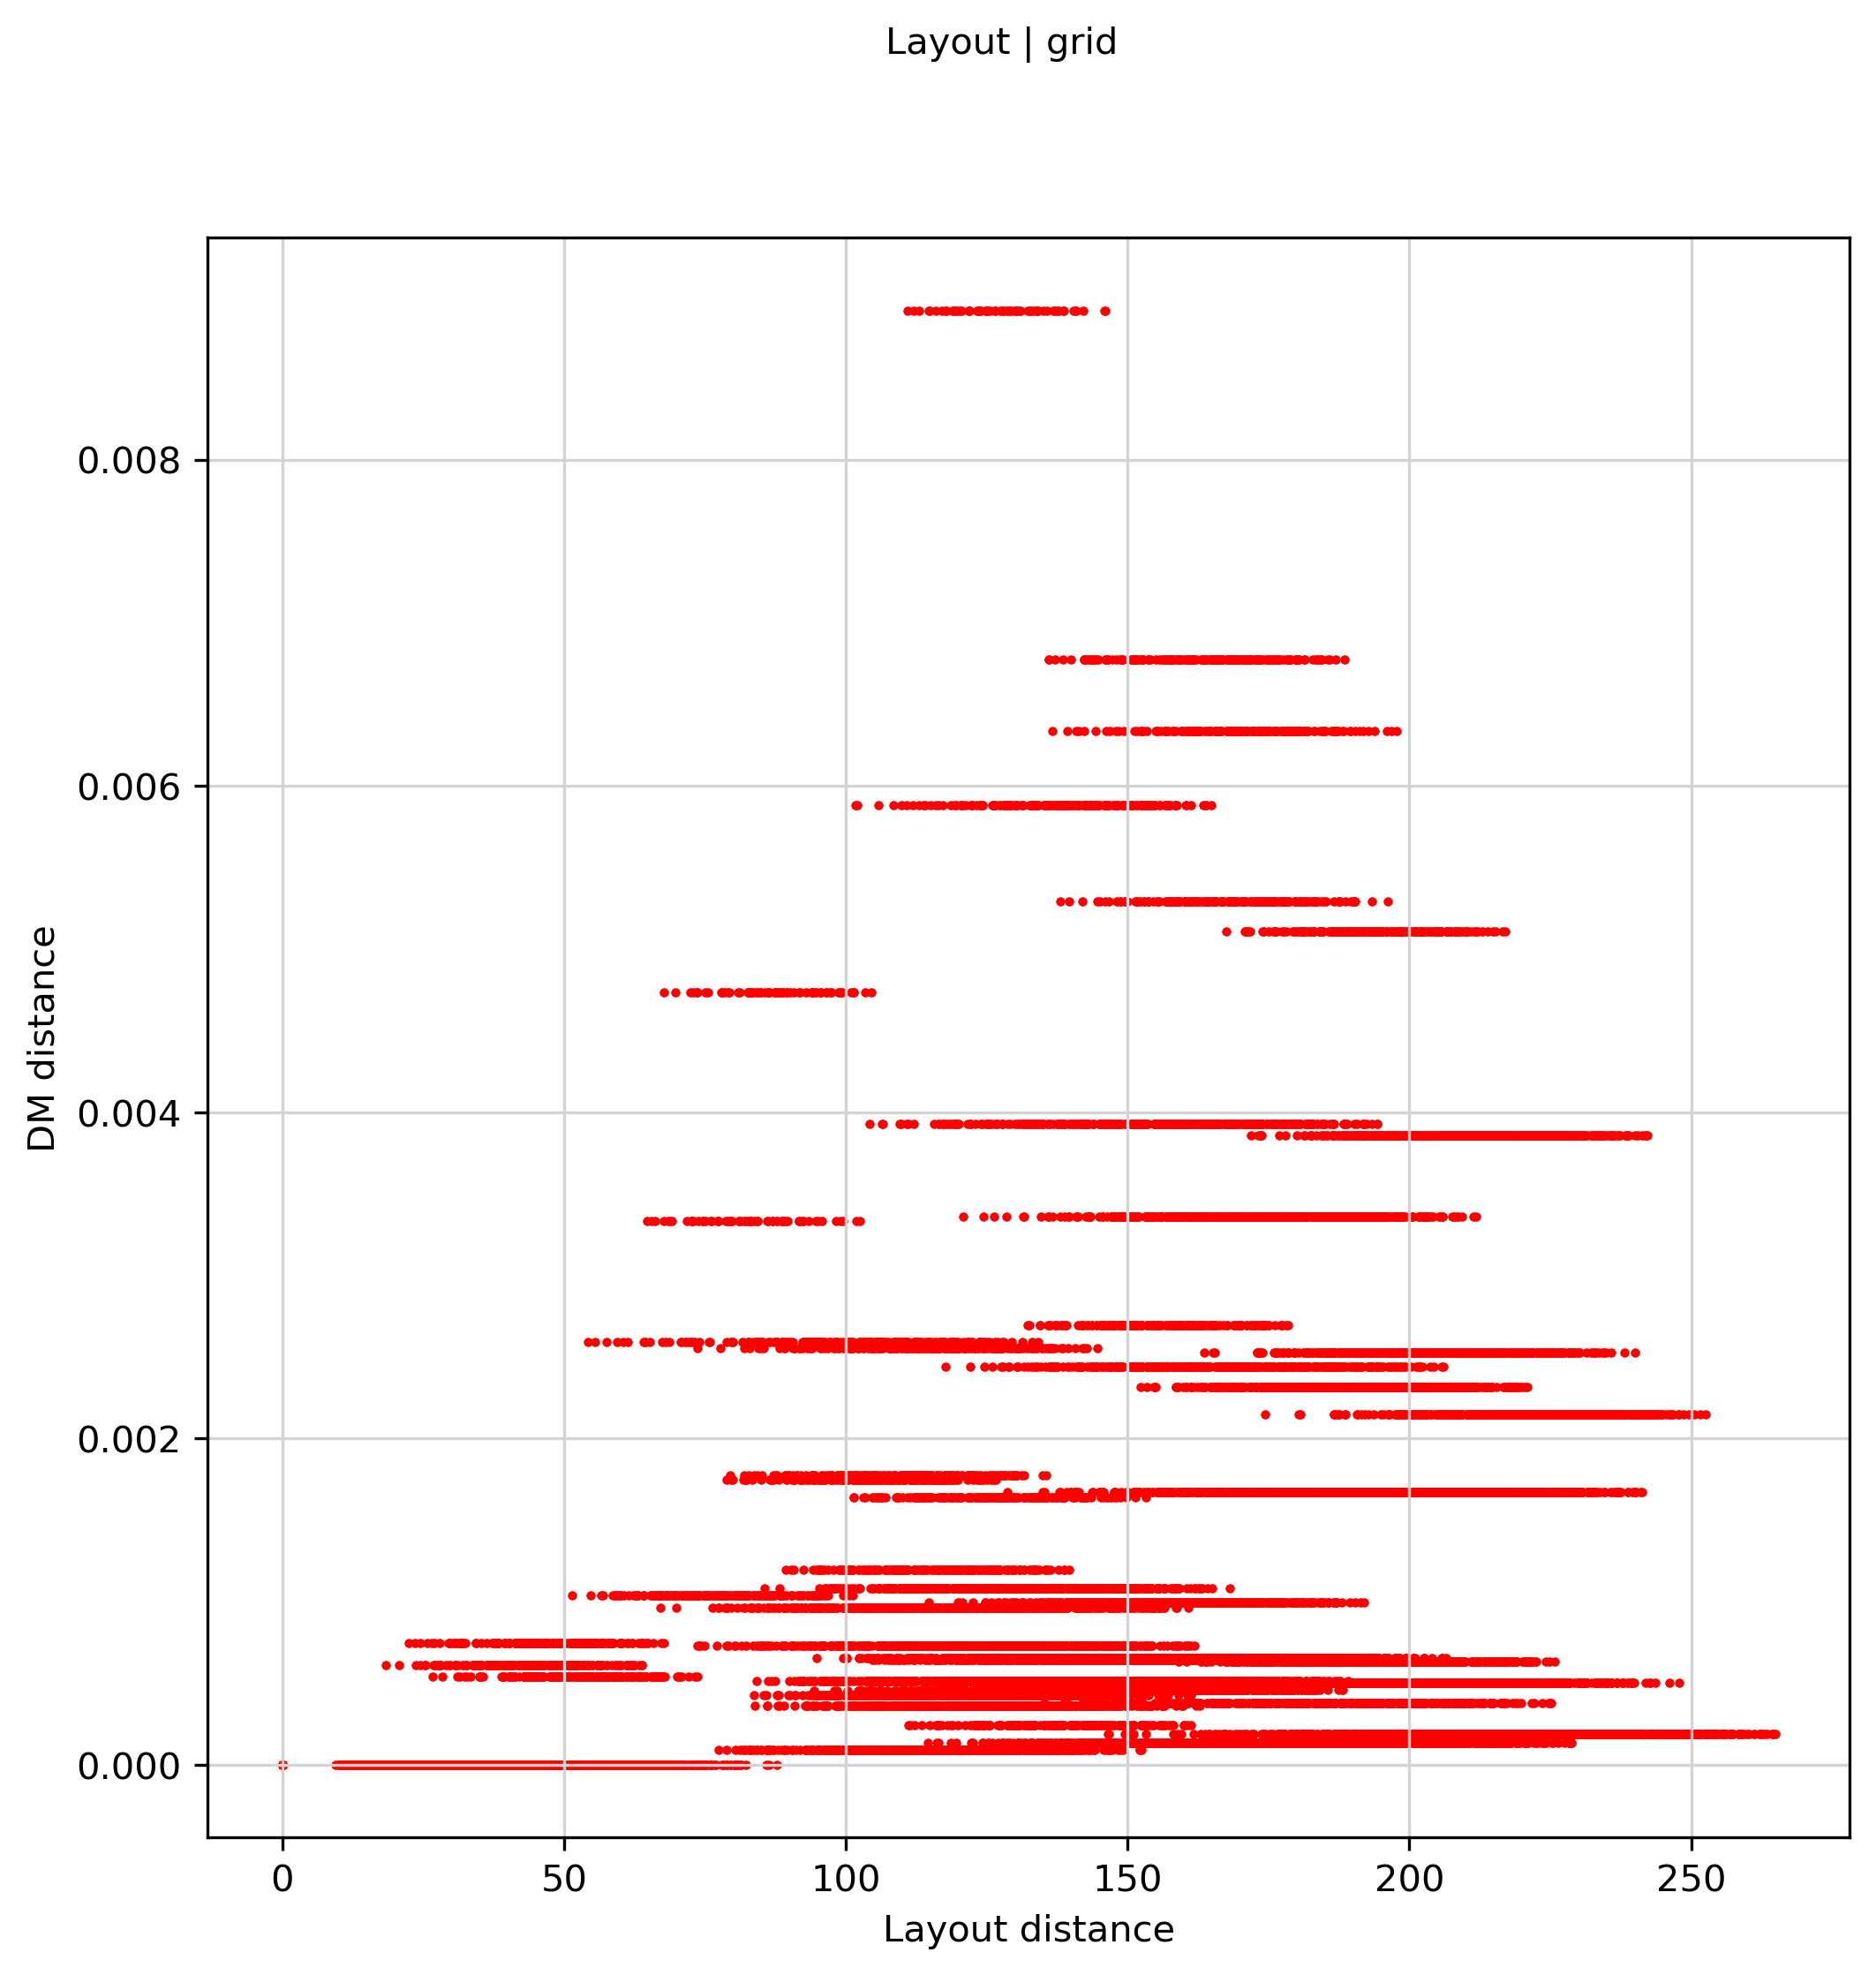

In [742]:
fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True,c='lightgrey')

#for i in df_layout3D:
#    plt.scatter(df_layout3D.values[i],DM.values[i], c = 'red', s = 2)

plt.scatter(df_layout3D.values,DM.values, c = 'red', s = 2)

plt.xlabel("Layout distance", fontsize=10)
plt.ylabel("DM distance", fontsize=10)

fig.suptitle('Layout | '+organism, fontsize=10)

#for i in range(len(df_layout3D)):
#    slope, intercept, r_value, p_value, std_err = stats.linregress(df_layout3D.values[i],DM.values[i])
#    line = slope*df_layout3D.values[i]+intercept
#    plt.plot(df_layout3D.values[0], line, c='darkred',linewidth=1.0, label='y={:.2f}x+{:.2f}'.format(slope,intercept))

#plt.legend(fontsize=14)

fig.savefig('output_plots/3Dtoynetwork_CorrDiagramLAYOUT_'+feature+'_'+organism+'.png')

# Statistical Test for correlation between data sets (DMs to Layouts): 
### Pearson Correlation
+ Pearson product-moment correlation coefficients
+ The relationship between the correlation coefficient matrix, R, and the covariance matrix, C
+ Value can range from -1 to 1, the closer to 1 the more positive linear correlation ( the closer to -1 the more negative linear correlation)

In [743]:
# Pearson Correlation coefficient comparison of Spring- to Layouts-coordinates

print('Number of Nodes: ', len(G.nodes()))
print('Organism: ', organism)

print('-----------------')

print('2D')
pearson_spring = np.corrcoef(df_spring2D, DM)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring),10))

pearson_layout = np.corrcoef(df_layout2D, DM)
print('Layout: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_layout),10))

print('-----------------')

print('3D')
pearson_spring = np.corrcoef(df_spring3D, DM)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring),10))

pearson_layout = np.corrcoef(df_layout3D, DM)
print('Layout: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_layout),10))

Number of Nodes:  216
Organism:  grid
-----------------
2D
Spring: Mean of Pearson Correlation Coefficient:  0.1600584737
Layout: Mean of Pearson Correlation Coefficient:  0.1146510527
-----------------
3D
Spring: Mean of Pearson Correlation Coefficient:  0.1278735629
Layout: Mean of Pearson Correlation Coefficient:  0.1050919794


### Spearman Correlation 
+ to summarize the strength of the linear relationship between two data samples (Rank correlation)
+ Compared to Pearson: assumes a non-gaussian distribution and less sensitive to outliers that are in the tail of both samples - because of limiting the outliers to the value of their ranks 
+ Value can range from -1 to 1, the closer to 1 the more monotonic relationship between X and Y

In [744]:
# Spearman Correlation coefficient comparison of Spring- to Layouts-coordinates

from scipy.stats import spearmanr

print('Number of Nodes: ', len(G.nodes()))
print('Organism: ', organism)

print('-----------------')

print('2D')
spearman_spring, _ = spearmanr(df_spring2D, DM)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring),9))

spearman_layout, _ = spearmanr(df_layout2D, DM)
print('Layout: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_layout),9))

print('-----------------')

print('3D')
spearman_spring, _ = spearmanr(df_spring3D, DM)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring),9))

spearman_layout, _ = spearmanr(df_layout3D, DM)
print('Layout: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_layout),9))

Number of Nodes:  216
Organism:  grid
-----------------
2D
Spring: Mean of Spearman Correlation Coefficient:  0.108267866
Layout: Mean of Spearman Correlation Coefficient:  0.073184637
-----------------
3D
Spring: Mean of Spearman Correlation Coefficient:  0.083138009
Layout: Mean of Spearman Correlation Coefficient:  0.058152923
